In [141]:
import pandas as pd
import numpy as np

In [142]:
import torch
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import scikitplot as skplt

from torch.nn import Linear
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool

In [143]:
train_pos = pd.read_csv('train-positive.txt', header=None)
train_neg = pd.read_csv('train-negative.txt', header=None)
test_pos = pd.read_csv('test-positive.txt', header=None)
test_neg = pd.read_csv('test-negative.txt', header=None)

In [144]:
train_pos = pd.DataFrame([train_pos[::2].reset_index(drop=True)[0], train_pos[1::2].reset_index(drop=True)[0]]).T
train_neg = pd.DataFrame([train_neg[::2].reset_index(drop=True)[0], train_neg[1::2].reset_index(drop=True)[0]]).T
test_pos = pd.DataFrame([test_pos[::2].reset_index(drop=True)[0], test_pos[1::2].reset_index(drop=True)[0]]).T
test_neg = pd.DataFrame([test_neg[::2].reset_index(drop=True)[0], test_neg[1::2].reset_index(drop=True)[0]]).T

In [145]:
df = test_neg.append(test_pos).append(train_pos).append(train_neg).reset_index(drop=True)
df.iloc[:,0] = df.iloc[:,0].apply(lambda x: x.split(' ')[0][1:])
df.columns = ['bitter', 'seq']
df

,bitter,seq
0,Negative,AA
1,Negative,IKP
2,Negative,ILP
3,Negative,PFFDPQIP
4,Negative,IPQEVLP
...,...,...
635,Negative,NPPHQIYP
636,Negative,AIYK
637,Negative,ENGLPVHLDQSIFRRP
638,Negative,AMKPW


In [146]:
df = df.sample(frac=1, random_state=911)

In [147]:
df = df.sample(frac=1)
labels = df.bitter.apply(lambda x: 1 if x=='Positive' else 0).values
seq = df.seq.values

In [148]:
descriptors = list(set([j for i in seq for j in i]))
enc = OneHotEncoder()
X = np.array(descriptors).reshape((-1, 1))
enc_arrays = enc.fit(X)

In [149]:
def create_graph_data(str, label):
    n = len(str)
    edge_index_up = [[i, i+1] for i in range(n-1)]
    edge_index_down = [[i+1, i] for i in range(n-1)]
    edge_index = torch.tensor(edge_index_down + edge_index_up, dtype=torch.long)

    node_feats = enc.transform([[i] for i in str]).toarray()
    node_features = torch.tensor(node_feats, dtype=torch.float) 
    label = torch.tensor(label)
    d = Data(x = node_features, edge_index=edge_index.t().contiguous(), y = label)

    return(d)

In [150]:
data_list = []

In [151]:
for i in range(len(labels)):
    d = create_graph_data(seq[i], labels[i])

    data_list.append(d)

In [152]:
train_data, test_data = train_test_split(data_list, test_size=0.1)

In [153]:
train_loader = DataLoader(train_data, batch_size=64)
test_loader = DataLoader(test_data, batch_size=64)

In [154]:
for step, data in enumerate(train_loader):
    print(f'Step {step + 1}:')
    print('=======')
    print(f'Number of graphs in the current batch: {data.num_graphs}')
    print(data)
    print()

Step 1:
Number of graphs in the current batch: 64
DataBatch(x=[362, 20], edge_index=[2, 596], y=[64], batch=[362], ptr=[65])

Step 2:
Number of graphs in the current batch: 64
DataBatch(x=[312, 20], edge_index=[2, 496], y=[64], batch=[312], ptr=[65])

Step 3:
Number of graphs in the current batch: 64
DataBatch(x=[290, 20], edge_index=[2, 452], y=[64], batch=[290], ptr=[65])

Step 4:
Number of graphs in the current batch: 64
DataBatch(x=[272, 20], edge_index=[2, 416], y=[64], batch=[272], ptr=[65])

Step 5:
Number of graphs in the current batch: 64
DataBatch(x=[407, 20], edge_index=[2, 686], y=[64], batch=[407], ptr=[65])

Step 6:
Number of graphs in the current batch: 64
DataBatch(x=[365, 20], edge_index=[2, 602], y=[64], batch=[365], ptr=[65])

Step 7:
Number of graphs in the current batch: 64
DataBatch(x=[339, 20], edge_index=[2, 550], y=[64], batch=[339], ptr=[65])

Step 8:
Number of graphs in the current batch: 64
DataBatch(x=[365, 20], edge_index=[2, 602], y=[64], batch=[365], ptr

In [155]:
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = GCNConv(20, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.lin = Linear(hidden_channels, 2)


    def forward(self, x, edge_index, batch):
        # 1. Obtain node embeddings 
        x = self.conv1(x, edge_index)
        x = x.relu()
        x = self.conv2(x, edge_index)
        x = F.dropout(x, p =0.5, training = self.training)
        x = x.relu()
        x = self.conv3(x, edge_index)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.lin(x)
        
        return x

model = GCN(hidden_channels=64)
print(model)

GCN(
  (conv1): GCNConv(20, 64)
  (conv2): GCNConv(64, 64)
  (conv3): GCNConv(64, 64)
  (lin): Linear(in_features=64, out_features=2, bias=True)
)


In [156]:
model = GCN(hidden_channels=16)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()

    for data in train_loader:  # Iterate in batches over the training dataset.
         out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
         loss = criterion(out, data.y)  # Compute the loss.
         loss.backward()  # Derive gradients.
         optimizer.step()  # Update parameters based on gradients.
         optimizer.zero_grad()  # Clear gradients.

def test(loader):
     model.eval()

     correct = 0
     for data in loader:  # Iterate in batches over the training/test dataset.
         out = model(data.x, data.edge_index, data.batch)  
         pred = out.argmax(dim=1)  # Use the class with highest probability.
         correct += int((pred == data.y).sum())  # Check against ground-truth labels.
     return correct / len(loader.dataset)  # Derive ratio of correct predictions.

for epoch in range(1, 50):
    train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

Epoch: 001, Train Acc: 0.5660, Test Acc: 0.6094
Epoch: 002, Train Acc: 0.7101, Test Acc: 0.6875
Epoch: 003, Train Acc: 0.7361, Test Acc: 0.7812
Epoch: 004, Train Acc: 0.7535, Test Acc: 0.7500
Epoch: 005, Train Acc: 0.7656, Test Acc: 0.7812
Epoch: 006, Train Acc: 0.7847, Test Acc: 0.8125
Epoch: 007, Train Acc: 0.8003, Test Acc: 0.7812
Epoch: 008, Train Acc: 0.8194, Test Acc: 0.8125
Epoch: 009, Train Acc: 0.8299, Test Acc: 0.7969
Epoch: 010, Train Acc: 0.8229, Test Acc: 0.7969
Epoch: 011, Train Acc: 0.8351, Test Acc: 0.7969
Epoch: 012, Train Acc: 0.8299, Test Acc: 0.8125
Epoch: 013, Train Acc: 0.8455, Test Acc: 0.8125
Epoch: 014, Train Acc: 0.8281, Test Acc: 0.8125
Epoch: 015, Train Acc: 0.8438, Test Acc: 0.7812
Epoch: 016, Train Acc: 0.8420, Test Acc: 0.8281
Epoch: 017, Train Acc: 0.8490, Test Acc: 0.8281
Epoch: 018, Train Acc: 0.8507, Test Acc: 0.8125
Epoch: 019, Train Acc: 0.8507, Test Acc: 0.8281
Epoch: 020, Train Acc: 0.8507, Test Acc: 0.8281
Epoch: 021, Train Acc: 0.8594, Test Acc:

In [157]:
for data in test_loader:
    out = model(data.x, data.edge_index, data.batch)
    lab = data.y

In [158]:
out.shape

torch.Size([64, 2])

In [159]:
lab.shape

torch.Size([64])

<AxesSubplot:title={'center':'ROC Curves'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

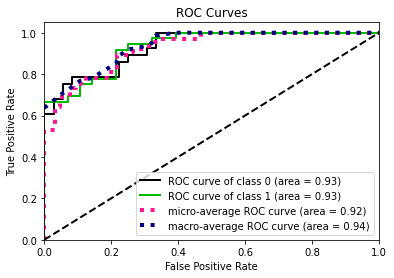

In [160]:
skplt.metrics.plot_roc(lab, out.detach().numpy())